<a href="https://colab.research.google.com/github/kridtapon/PolarisEdge/blob/main/PolarisEdge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninst

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

# Function: Polynomial Regression Moving Average (PRMA)
def prma(series, window, degree=2):
    return [np.polyval(np.polyfit(range(window), series[i:i+window], degree), window-1)
            for i in range(len(series) - window + 1)]

# Function: Chande Momentum Oscillator (CMO)
def chande_momentum_oscillator(df, period=14):
    df['Up'] = np.where(df['Close'] > df['Close'].shift(1), df['Close'] - df['Close'].shift(1), 0)
    df['Down'] = np.where(df['Close'] < df['Close'].shift(1), df['Close'].shift(1) - df['Close'], 0)
    df['SumUp'] = df['Up'].rolling(window=period).sum()
    df['SumDown'] = df['Down'].rolling(window=period).sum()
    df['CMO'] = 100 * (df['SumUp'] - df['SumDown']) / (df['SumUp'] + df['SumDown'])
    return df

# Define the stock symbol and time period
symbol = 'NQ=F'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)  # Handle missing data

# Calculate CMO
df = chande_momentum_oscillator(df, period=2)

# Calculate PRMA (Polynomial Regression Moving Averages) with different windows
fast_prma = prma(df['Close'], window=19, degree=2)
slow_prma = prma(df['Close'], window=45, degree=2)

# Align PRMA values to match original dataframe length
fast_prma = [np.nan] * (19 - 1) + fast_prma  # Padding with NaN for initial values
slow_prma = [np.nan] * (45 - 1) + slow_prma  # Padding with NaN for initial values

df['Fast_PRMA'] = fast_prma
df['Slow_PRMA'] = slow_prma

# Define Entry and Exit Signals based on PRMA crossovers
df['Entry'] = (
    (df['CMO'] < -50) &  # CMO is below -50
    (df['Fast_PRMA'] > df['Slow_PRMA'])  # Current Fast PRMA crosses above Slow PRMA
)

df['Exit'] = (
    (df['CMO'] > 50) &  # CMO is above +50
    (df['Fast_PRMA'] < df['Slow_PRMA'])  # Current Fast PRMA crosses below Slow PRMA
)

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1259
Start Value                              100000.0
End Value                           332606.740597
Total Return [%]                       232.606741
Benchmark Return [%]                   138.721287
Max Gross Exposure [%]                      100.0
Total Fees Paid                      16384.991857
Max Drawdown [%]                         15.62185
Max Drawdown Duration                       271.0
Total Trades                                   39
Total Closed Trades                            39
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            79.487179
Best Trade [%]                          22.888779
Worst Trade [%]                          -8.87139
Avg Winning Trade [%]                     5.04157
Avg Losing Trade [%]                     -3.54073


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

# Function: Polynomial Regression Moving Average (PRMA)
def prma(series, window, degree=2):
    return [np.polyval(np.polyfit(range(window), series[i:i+window], degree), window-1)
            for i in range(len(series) - window + 1)]

# Function: Chande Momentum Oscillator (CMO)
def chande_momentum_oscillator(df, period=14):
    df['Up'] = np.where(df['Close'] > df['Close'].shift(1), df['Close'] - df['Close'].shift(1), 0)
    df['Down'] = np.where(df['Close'] < df['Close'].shift(1), df['Close'].shift(1) - df['Close'], 0)
    df['SumUp'] = df['Up'].rolling(window=period).sum()
    df['SumDown'] = df['Down'].rolling(window=period).sum()
    df['CMO'] = 100 * (df['SumUp'] - df['SumDown']) / (df['SumUp'] + df['SumDown'])
    return df

# Define the stock symbol and time period
symbol = 'NQ=F'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)  # Handle missing data

# Function to optimize parameters
def optimize_parameters(cmo_periods, fast_windows, slow_windows):
    best_total_return = -np.inf
    best_params = None
    best_portfolio = None

    # Grid search over CMO periods, fast PRMA windows, and slow PRMA windows
    param_grid = ParameterGrid({
        'cmo_period': cmo_periods,
        'fast_window': fast_windows,
        'slow_window': slow_windows
    })

    for params in param_grid:
        # Reload the original dataframe for each iteration
        df_copy = df.copy()

        # Calculate CMO with current period
        df_copy = chande_momentum_oscillator(df_copy, period=params['cmo_period'])

        # Calculate PRMA with different windows
        fast_prma = prma(df_copy['Close'], window=params['fast_window'], degree=2)
        slow_prma = prma(df_copy['Close'], window=params['slow_window'], degree=2)

        # Align PRMA values to match original dataframe length
        fast_prma = [np.nan] * (params['fast_window'] - 1) + fast_prma
        slow_prma = [np.nan] * (params['slow_window'] - 1) + slow_prma

        df_copy['Fast_PRMA'] = fast_prma
        df_copy['Slow_PRMA'] = slow_prma

        # Define Entry and Exit Signals based on PRMA crossovers
        df_copy['Entry'] = (
            (df_copy['CMO'] < -50) &  # CMO is below -50
            (df_copy['Fast_PRMA'] > df_copy['Slow_PRMA'])  # Current Fast PRMA crosses above Slow PRMA
        )

        df_copy['Exit'] = (
            (df_copy['CMO'] > 50) &  # CMO is above +50
            (df_copy['Fast_PRMA'] < df_copy['Slow_PRMA'])  # Current Fast PRMA crosses below Slow PRMA
        )

        # Convert signals to boolean arrays
        entries = df_copy['Entry'].to_numpy()
        exits = df_copy['Exit'].to_numpy()

        # Backtest using vectorbt
        portfolio = vbt.Portfolio.from_signals(
            close=df_copy['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        # Calculate Total Return for performance
        total_return = portfolio.stats()['Total Return [%]']

        # Keep track of the best parameters based on Total Return
        if total_return > best_total_return:
            best_total_return = total_return
            best_params = params
            best_portfolio = portfolio

    return best_params, best_portfolio

# Set parameter ranges
cmo_periods = range(21, 31)  # CMO periods from 1 to 50
fast_windows = range(10, 51)  # Fast PRMA windows from 1 to 50
slow_windows = range(10, 51)  # Slow PRMA windows from 1 to 50

# Find the best parameters
best_params, best_portfolio = optimize_parameters(cmo_periods, fast_windows, slow_windows)

# Display the best parameters and portfolio stats
print(f"Best Parameters: {best_params}")
print(best_portfolio.stats())

# Plot the equity curve of the best portfolio
best_portfolio.plot().show()


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builde

Best Parameters: {'cmo_period': 21, 'fast_window': 33, 'slow_window': 31}
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1259
Start Value                              100000.0
End Value                           119554.509808
Total Return [%]                         19.55451
Benchmark Return [%]                   138.721287
Max Gross Exposure [%]                      100.0
Total Fees Paid                        219.574284
Max Drawdown [%]                        29.595905
Max Drawdown Duration                       305.0
Total Trades                                    1
Total Closed Trades                             1
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                100.0
Best Trade [%]                          19.574064
Worst Trade [%]                         19.574064
Avg Winning Trade [%]     

In [2]:
pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


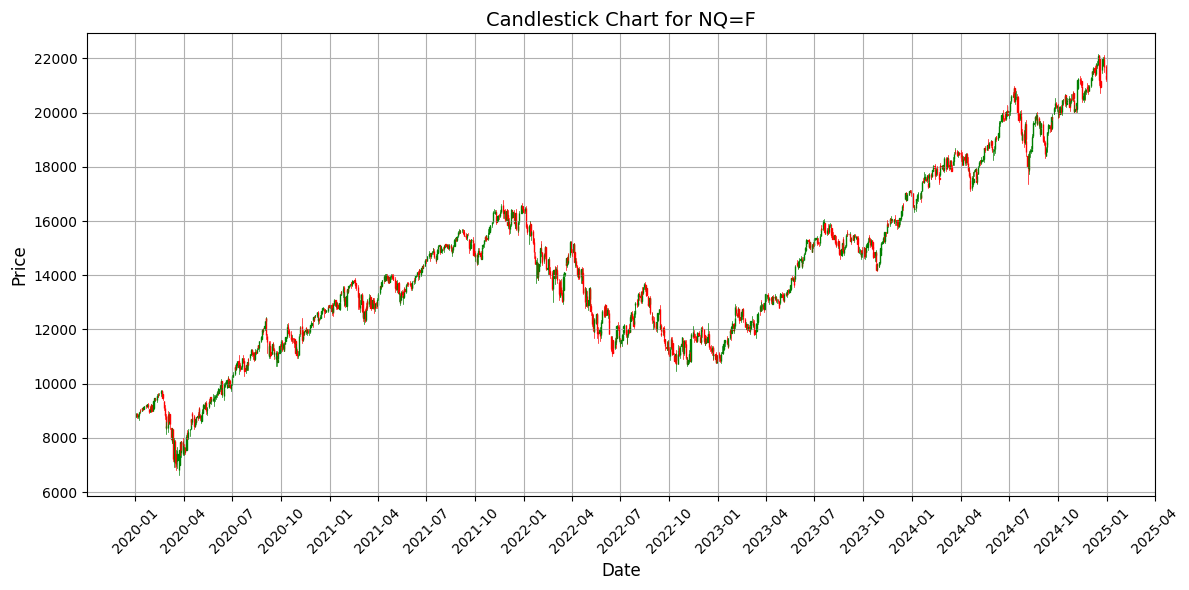

In [3]:
import yfinance as yf
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd

# Define the stock symbol and time period
symbol = 'NQ=F'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)

# Prepare the data for the candlestick chart
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].apply(mdates.date2num)  # Convert dates to numeric format for candlestick_ohlc

data = df[['Date', 'Open', 'High', 'Low', 'Close']]

# Plot the candlestick chart
fig, ax = plt.subplots(figsize=(12, 6))
candlestick_ohlc(ax, data.values, width=0.6, colorup='green', colordown='red')

# Format the plot
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.set_title(f'Candlestick Chart for {symbol}', fontsize=14)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.grid(True)

# Rotate and align the date labels
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


[*********************100%***********************]  1 of 1 completed


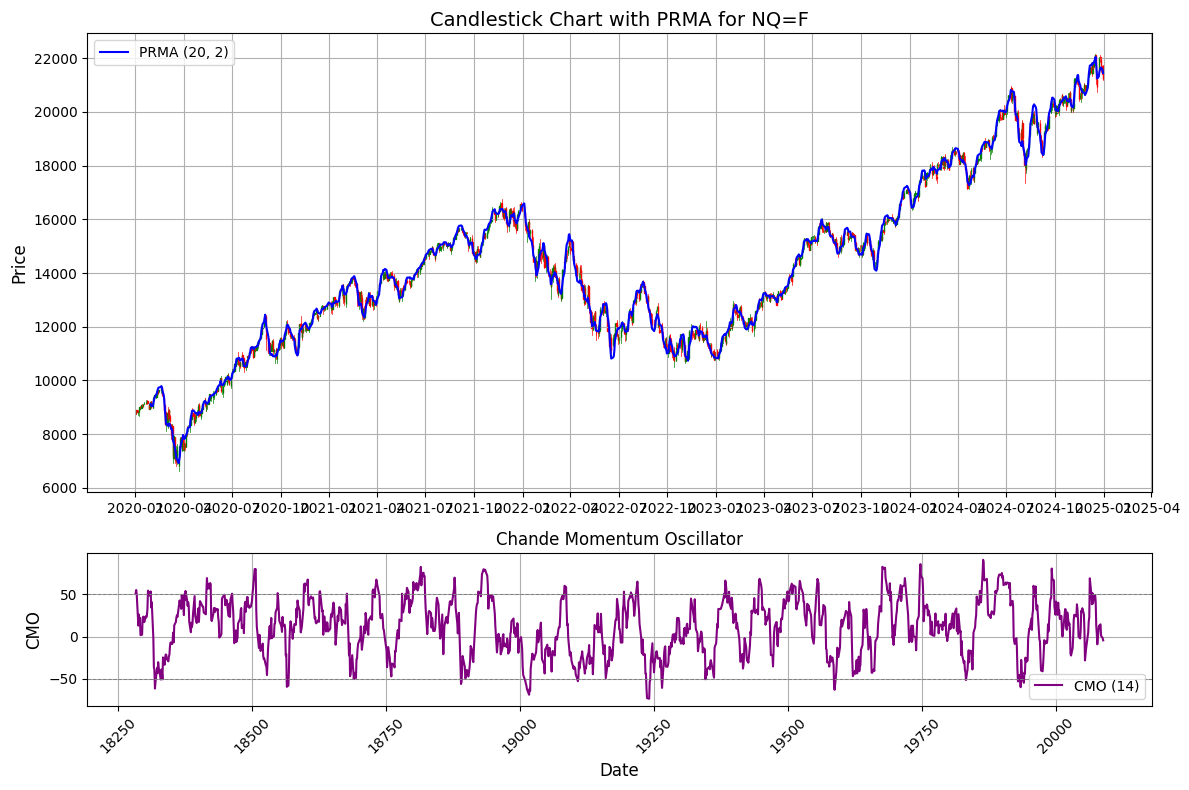

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

# Function: Polynomial Regression Moving Average (PRMA)
def prma(series, window, degree=2):
    return [
        np.polyval(np.polyfit(range(window), series[i:i+window], degree), window-1)
        for i in range(len(series) - window + 1)
    ]

# Function: Chande Momentum Oscillator (CMO)
def chande_momentum_oscillator(df, period=14):
    df['Up'] = np.where(df['Close'] > df['Close'].shift(1), df['Close'] - df['Close'].shift(1), 0)
    df['Down'] = np.where(df['Close'] < df['Close'].shift(1), df['Close'].shift(1) - df['Close'], 0)
    df['SumUp'] = df['Up'].rolling(window=period).sum()
    df['SumDown'] = df['Down'].rolling(window=period).sum()
    df['CMO'] = 100 * (df['SumUp'] - df['SumDown']) / (df['SumUp'] + df['SumDown'])
    return df

# Download stock data
def download_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df.reset_index(inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].apply(mdates.date2num)  # Convert dates to numeric format
    return df

# Plot data with indicators
def plot_with_indicators(df, symbol, prma_window, prma_degree, cmo_period):
    # Prepare data for candlestick chart
    data = df[['Date', 'Open', 'High', 'Low', 'Close']]

    # Calculate PRMA
    df['PRMA'] = np.nan
    prma_values = prma(df['Close'].values, prma_window, prma_degree)
    df.loc[prma_window-1:, 'PRMA'] = prma_values

    # Calculate CMO
    df = chande_momentum_oscillator(df, cmo_period)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Plot candlestick chart and PRMA
    candlestick_ohlc(ax1, data.values, width=0.6, colorup='green', colordown='red')
    ax1.plot(df['Date'], df['PRMA'], label=f'PRMA ({prma_window}, {prma_degree})', color='blue', linewidth=1.5)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax1.set_title(f'Candlestick Chart with PRMA for {symbol}', fontsize=14)
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Plot CMO
    ax2.plot(df['Date'], df['CMO'], label=f'CMO ({cmo_period})', color='purple', linewidth=1.5)
    ax2.axhline(50, color='grey', linestyle='--', linewidth=0.7)
    ax2.axhline(-50, color='grey', linestyle='--', linewidth=0.7)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('CMO', fontsize=12)
    ax2.set_title('Chande Momentum Oscillator', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    # Rotate and align the date labels
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Define parameters
symbol = 'NQ=F'
start_date = '2020-01-01'
end_date = '2025-01-01'
prma_window = 20
prma_degree = 2
cmo_period = 14

# Main execution
df = download_data(symbol, start_date, end_date)
plot_with_indicators(df, symbol, prma_window, prma_degree, cmo_period)
